In [1]:
import torch
import torchvision
from torch import nn

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [3]:
def showBatchImg(images,labels,maxNum=5):
    fig, axes = plt.subplots(1, maxNum)
    for i in range(min(maxNum,images.shape[0])):
        axes[i].imshow(images[i].squeeze())
        axes[i].set_title(labels[i].item())
        axes[i].axis('off')

# images, labels = next(iter(trainloader))
# showBatchImg(images, labels, 10)
# print(images.shape)

## Load DataSet

In [4]:
## Load DataSet

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((28,28)),
        torchvision.transforms.ToTensor()
     ])

batch_size = 1000

trainset = torchvision.datasets.MNIST(root='L:/Datasets', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)

torch.Size([1000, 1, 28, 28])


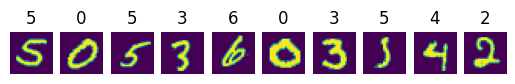

In [5]:
images, labels = next(iter(trainloader))
showBatchImg(images, labels, 10)
print(images.shape)

## DCGAN
```
Generator:  [noise] ==> Fake_Img  

Discriminator:  [Img] ==> Fake/Real

Loss: D+G，其中D希望正确区分、即令Fake=0/Real=1，G希望令Fake=1
```
【感谢Yuan Xiao的debug，不过似乎G还是太弱？？】  
 https://github.com/pytorch/examples/blob/main/dcgan/main.py 更清晰

In [6]:
## Model
## noiseShape = (64,3,3)
class Generator_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.Generator = nn.Sequential(           ## B*64*3*3  (B*C *H*W)
            ##  in_channel,out_channel,kernel_size
            nn.ConvTranspose2d(64,32,6,stride=2),          ## ==> B*32* 10*10      H = (H-1)*strides + kernel_size
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32,8,(6,6), stride=(2, 2)), ## ==> B*8*  24*24
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8,1,5,stride=1),            ## ==> B*1*  28*28
            nn.Sigmoid()
        )
    def forward(self,noise):
        return self.Generator(noise)

class Discriminator_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.Discriminator = nn.Sequential(
            nn.Conv2d(1,6,(5,5)),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(6,16,(5,5)),
            nn.Flatten(),
            nn.Linear(16*8*8,128),
            nn.LeakyReLU(),
            nn.Linear(128,1),
            nn.Sigmoid(),
        )
    def forward(self,x):
        return self.Discriminator(x)

modelG = Generator_Net().to(device)
print(modelG)
modelD = Discriminator_Net().to(device)
print(modelD)

Generator_Net(
  (Generator): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(32, 8, kernel_size=(6, 6), stride=(2, 2))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(1, 1))
    (7): Sigmoid()
  )
)
Discriminator_Net(
  (Discriminator): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=1024, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [7]:
optimizerG = torch.optim.Adam(modelG.parameters(), lr=2e-3)
optimizerD = torch.optim.Adam(modelD.parameters(), lr=2e-3)

def lossGfn(predF):
    return nn.BCELoss()(predF,torch.ones_like(predF))

def lossDfn(predF,predR):
    lossFake = nn.BCELoss()(predF,torch.zeros_like(predF))
    lossReal = nn.BCELoss()(predR,torch.ones_like(predR))
    return lossFake+lossReal

def train(dataloader, modelG, modelD, lossGfn, lossDfn, optimizerG, optimizerD, D_Train=True):
    lossSumG = 0
    lossSumD = 0
    modelG.train()
    modelD.train()
    for batch, (RealImgs, y) in enumerate(dataloader):
        RealImgs = RealImgs.to(device)
        # Update discriminator
        optimizerD.zero_grad()
        noise = torch.randn(batch_size, 64,3,3, device=device)
        FakeImgs = modelG(noise)
        predF = modelD(FakeImgs.detach())
        predR = modelD(RealImgs)
        lossD = lossDfn(predF,predR)
        lossD.backward(retain_graph=True)
        optimizerD.step()
        # Update generator
        optimizerG.zero_grad()
        predF = modelD(FakeImgs)
        lossG = lossGfn(predF)
        lossG.backward()
        optimizerG.step()
        ## Collect loss
        lossSumG += lossG
        lossSumD += lossD
    return lossSumG, lossSumD

In [8]:
for epoch in range(20):
    lossG,lossD = train(trainloader, modelG, modelD, lossGfn, lossDfn, optimizerG, optimizerD, D_Train=True)
    print(f'Epoch {epoch+1}----Generator Loss:: {lossG:>7f}----Discriminator Loss:: {lossD:>7f}')

Epoch 1----Generator Loss:: 158.909210----Discriminator Loss:: 31.298594
Epoch 2----Generator Loss:: 144.577850----Discriminator Loss:: 56.280388
Epoch 3----Generator Loss:: 140.091248----Discriminator Loss:: 39.815174
Epoch 4----Generator Loss:: 182.664093----Discriminator Loss:: 29.977863
Epoch 5----Generator Loss:: 186.016052----Discriminator Loss:: 27.960615
Epoch 6----Generator Loss:: 198.548264----Discriminator Loss:: 22.562410
Epoch 7----Generator Loss:: 230.158630----Discriminator Loss:: 18.504894
Epoch 8----Generator Loss:: 253.332581----Discriminator Loss:: 16.472372
Epoch 9----Generator Loss:: 258.370209----Discriminator Loss:: 14.333111
Epoch 10----Generator Loss:: 285.147156----Discriminator Loss:: 12.048318
Epoch 11----Generator Loss:: 299.491425----Discriminator Loss:: 13.262466
Epoch 12----Generator Loss:: 287.943298----Discriminator Loss:: 13.863405
Epoch 13----Generator Loss:: 316.571320----Discriminator Loss:: 14.635000
Epoch 14----Generator Loss:: 336.174652----Disc

torch.Size([10, 1, 28, 28])


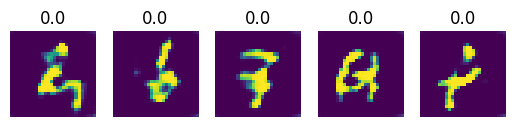

In [9]:
## Use Prediction
modelG.eval()
noise = torch.randn(10, 64,3,3, device=device)  ## B*noiseShape
FakeImgs = modelG(noise)
print(FakeImgs.shape)
showBatchImg(FakeImgs.detach().cpu(), np.zeros(FakeImgs.shape[0]))